In [4]:
%matplotlib notebook
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
sns.set()

In [2]:
# Date time

def toUnixEpoch(y, m, d):
    return int(datetime(y, m, d, 0, 0).timestamp())

In [3]:
# Load data

json_file = open('hash-power.json')
data = json.load(json_file)
H_t = data['values']

<IPython.core.display.Javascript object>


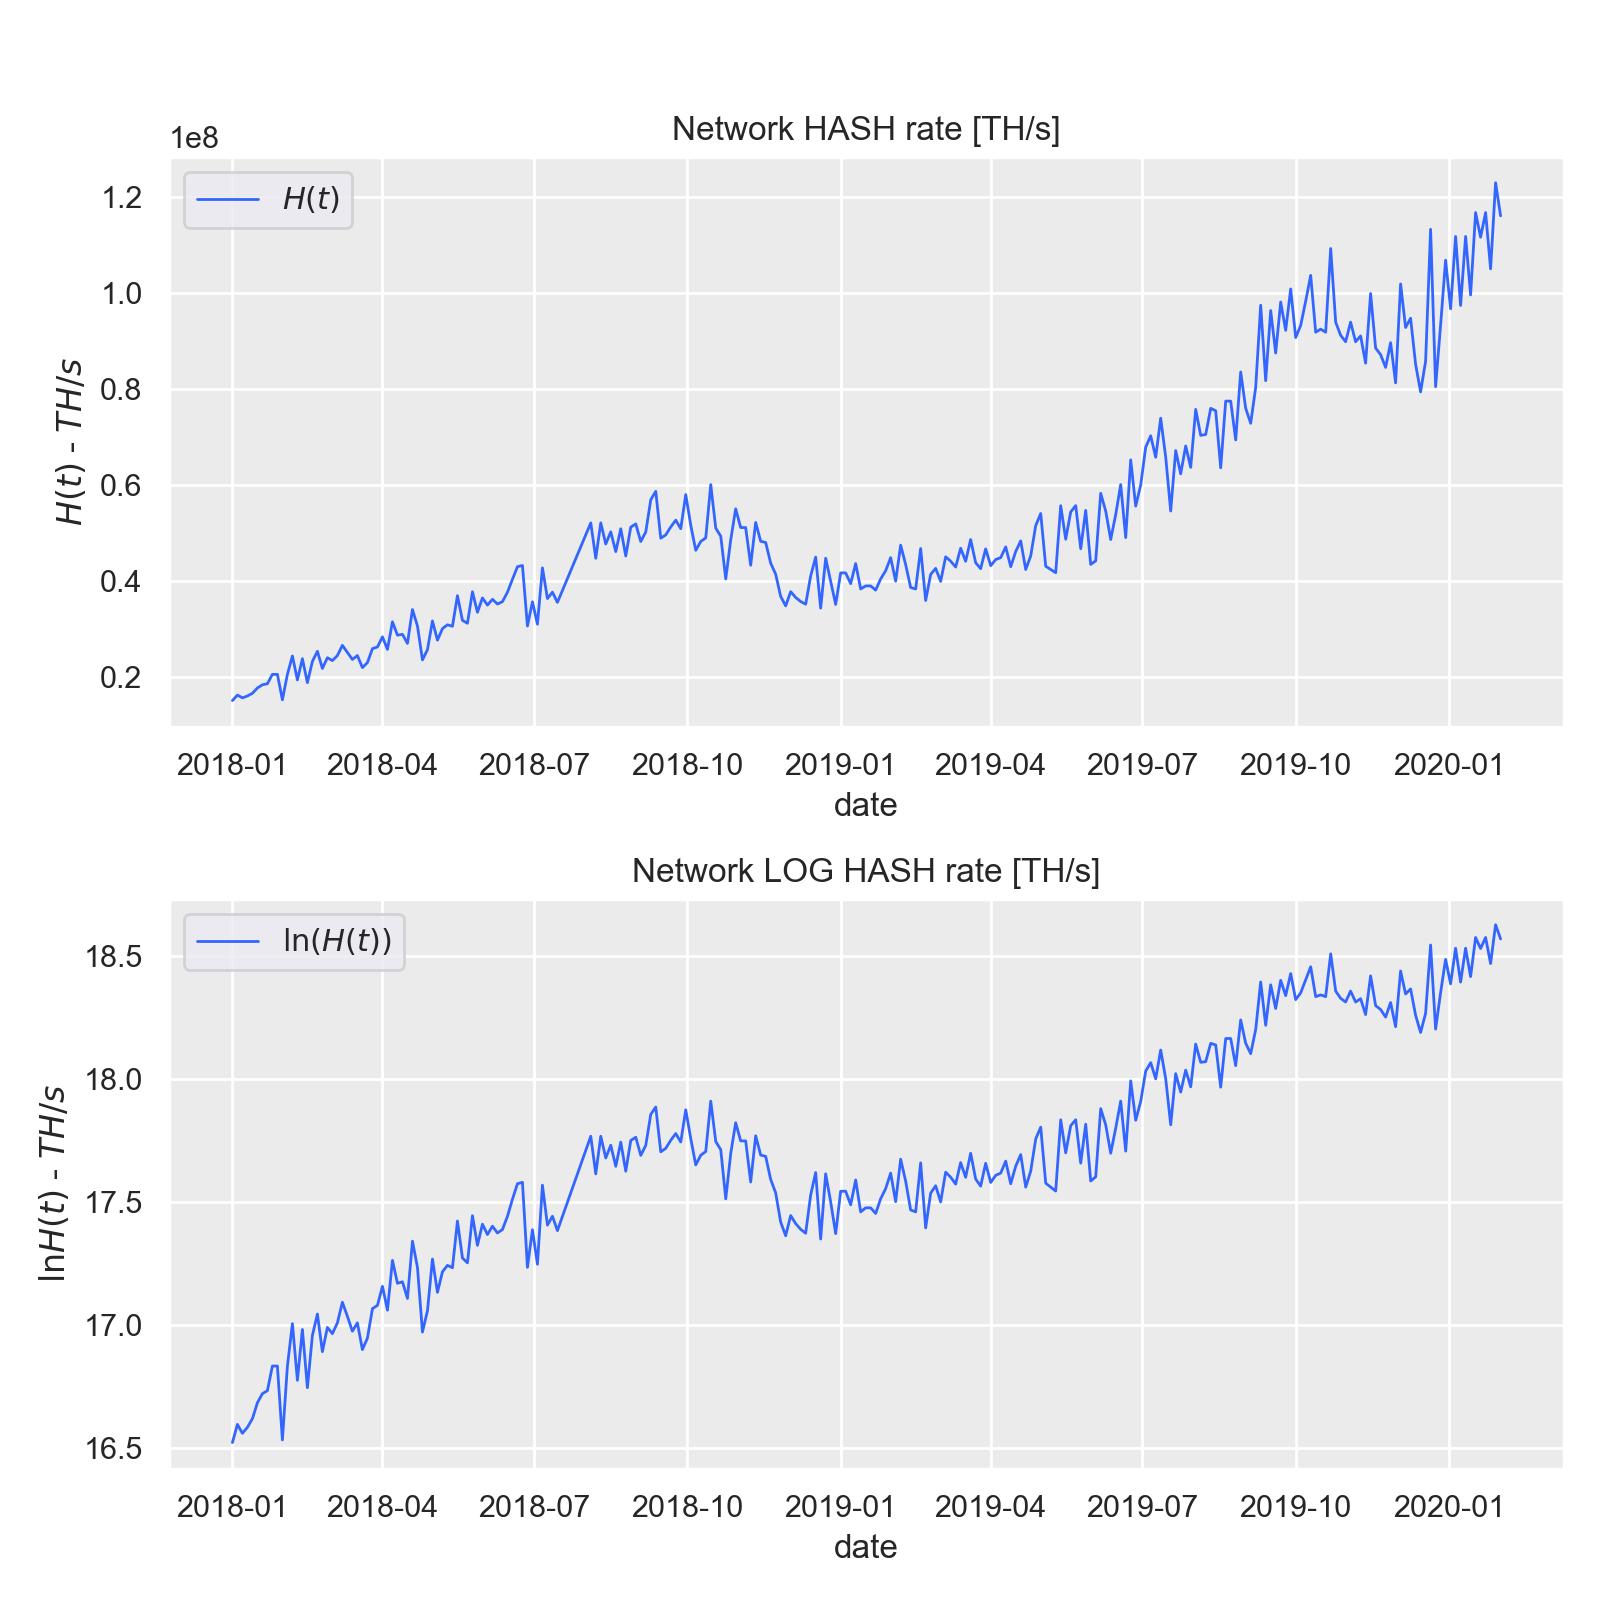

In [5]:
# Visualization

H_d = [(d['x'], d['y']) for d in H_t if int(d['x']) > toUnixEpoch(2018, 1, 1)]
Ts = [datetime.fromtimestamp(int(x[0])) for x in H_d]

H = [float(x[1]) for x in H_d]

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top=.90)

ax1 = fig.add_subplot(211)
ax1.set_facecolor('#EBEBEB')
ax1.set_title('Network HASH rate [TH/s]')
ax1.set_ylabel('$H(t)$ - $TH/s$')
ax1.set_xlabel('date')
ax1.plot(Ts, H, label='$H(t)$', c='#3366FF', linewidth=1)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_facecolor('#EBEBEB')
ax2.set_title('Network LOG HASH rate [TH/s]')
ax2.set_ylabel('$\ln{H(t)}$ - $TH/s$')
ax2.set_xlabel('date')
ax2.plot(Ts, np.log(H), label='$\ln(H(t))$', c='#3366FF', linewidth=1)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [6]:
T = [float(x[0]) for x in H_d]
H = [float(x[1]) for x in H_d]

x = np.array(T)
y = np.array(np.log(H))
X = np.vstack([x, np.ones(len(x))]).T

reg = LinearRegression().fit(X, y)

print('score: {0:.3f}'.format(reg.score(X, y)))
print(reg.coef_)
print(reg.intercept_)

score: 0.839
[2.30816494e-08 0.00000000e+00]
-18.04550761099243


<IPython.core.display.Javascript object>


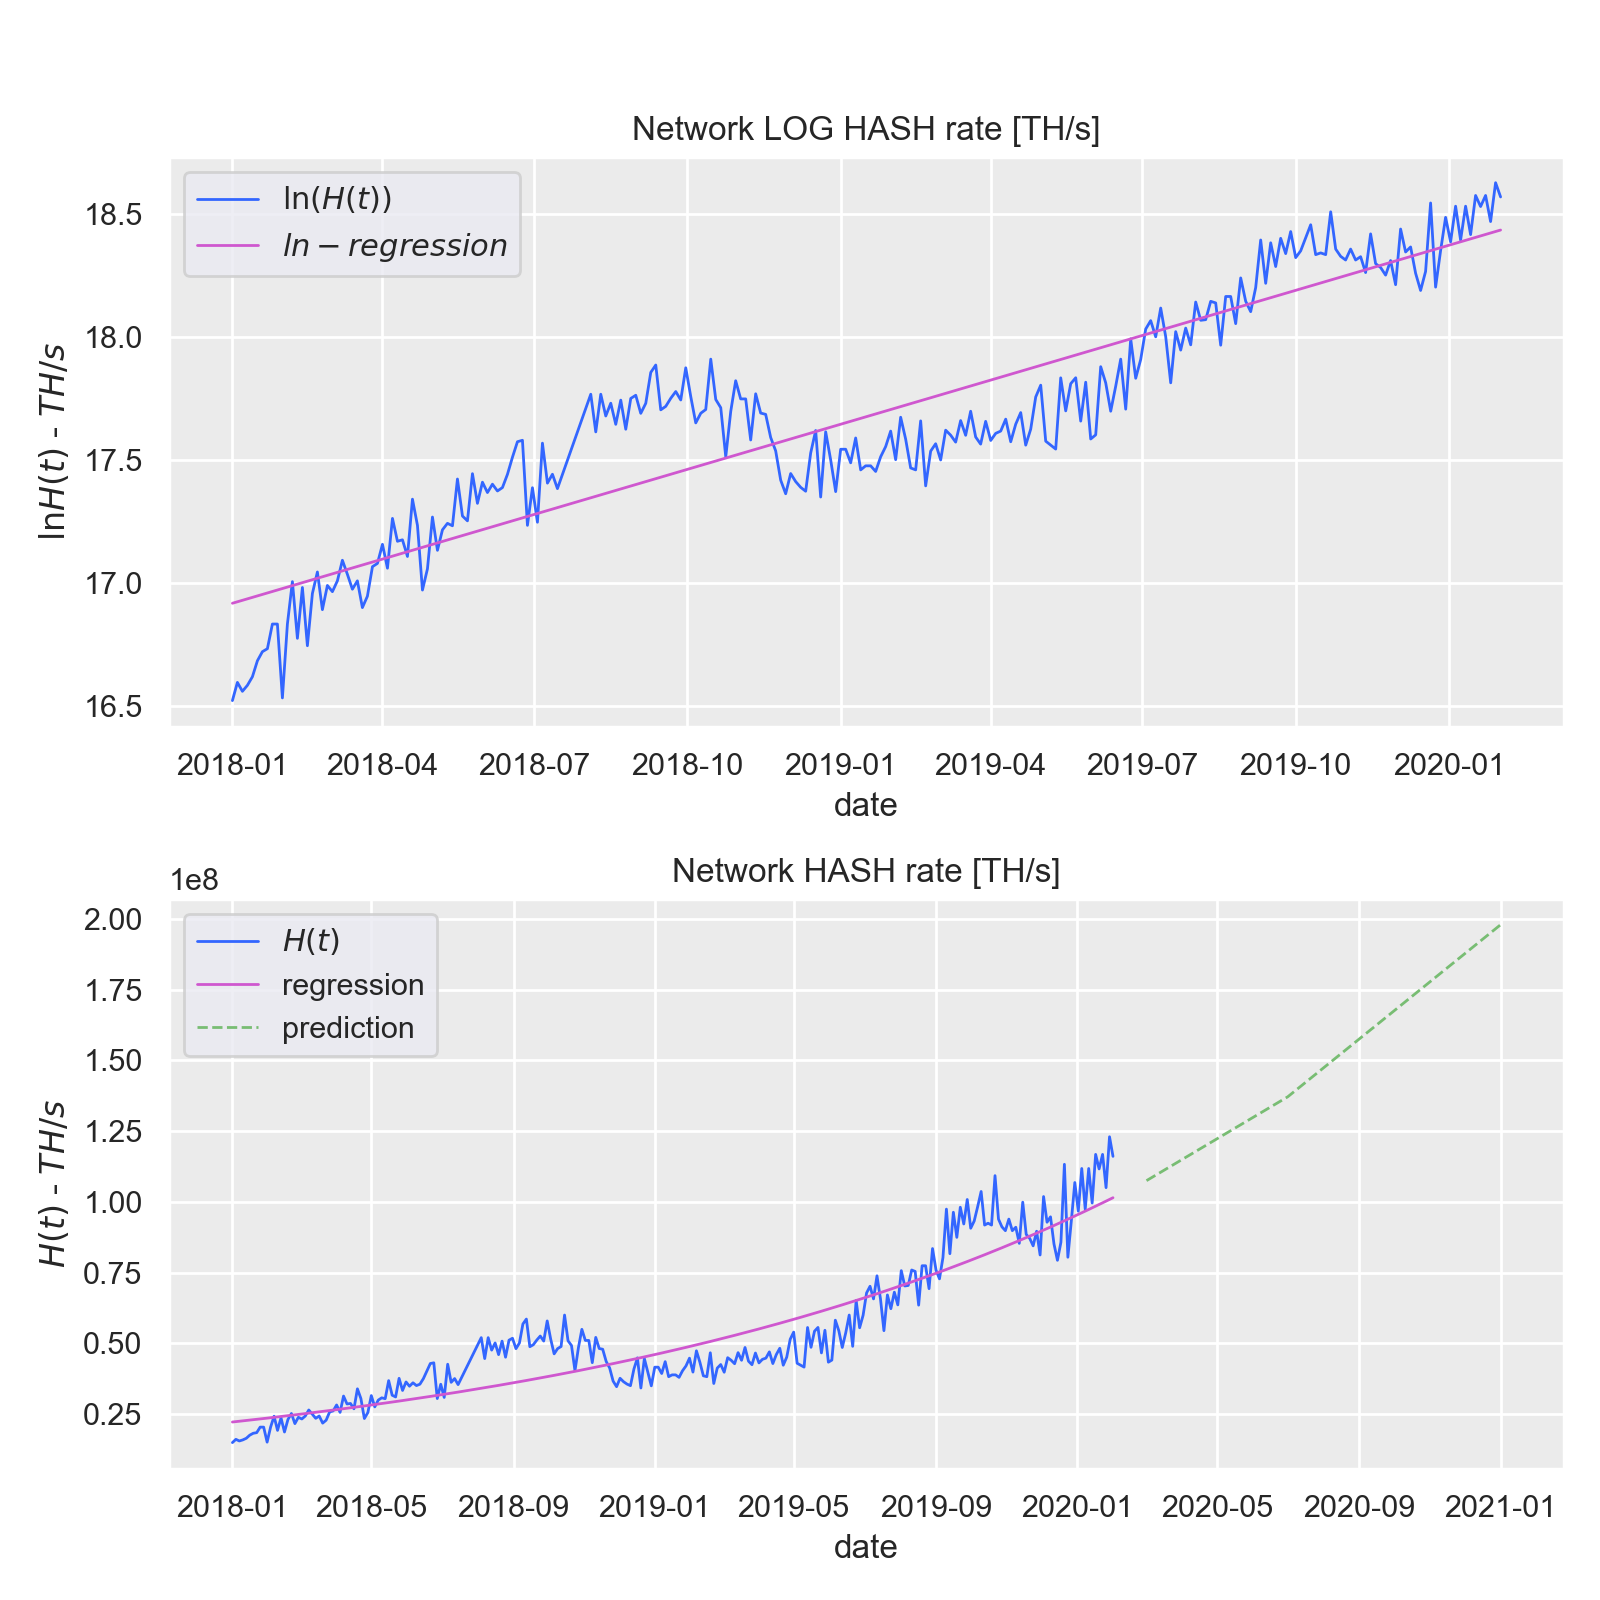

In [7]:

f = [toUnixEpoch(2020, 3, 1), toUnixEpoch(2020, 7, 1), toUnixEpoch(2021, 1, 1)]
p = np.array(f)
P = np.vstack([p, np.ones(len(p))]).T
PTs = [datetime.fromtimestamp(x) for x in f]

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top=.90)

ax1 = fig.add_subplot(211)
ax1.set_facecolor('#EBEBEB')
ax1.set_title('Network LOG HASH rate [TH/s]')
ax1.set_ylabel('$\ln{H(t)}$ - $TH/s$')
ax1.set_xlabel('date')

ax1.plot(Ts, np.log(H), label='$\ln(H(t))$', c='#3366FF', linewidth=1)
ax1.plot(Ts, reg.predict(X) , label='$ln-regression$', c='#CF57CF', linewidth=1)

ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_facecolor('#EBEBEB')
ax2.set_title('Network HASH rate [TH/s]')
ax2.set_ylabel('$H(t)$ - $TH/s$')
ax2.set_xlabel('date')
ax2.plot(Ts, H, label='$H(t)$', c='#3366FF', linewidth=1)
ax2.plot(Ts, np.exp(reg.predict(X)) , label='regression', c='#CF57CF', linewidth=1)
ax2.plot(PTs, np.exp(reg.predict(P)) , label='prediction', c='#78BD73', linewidth=1, ls='--')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


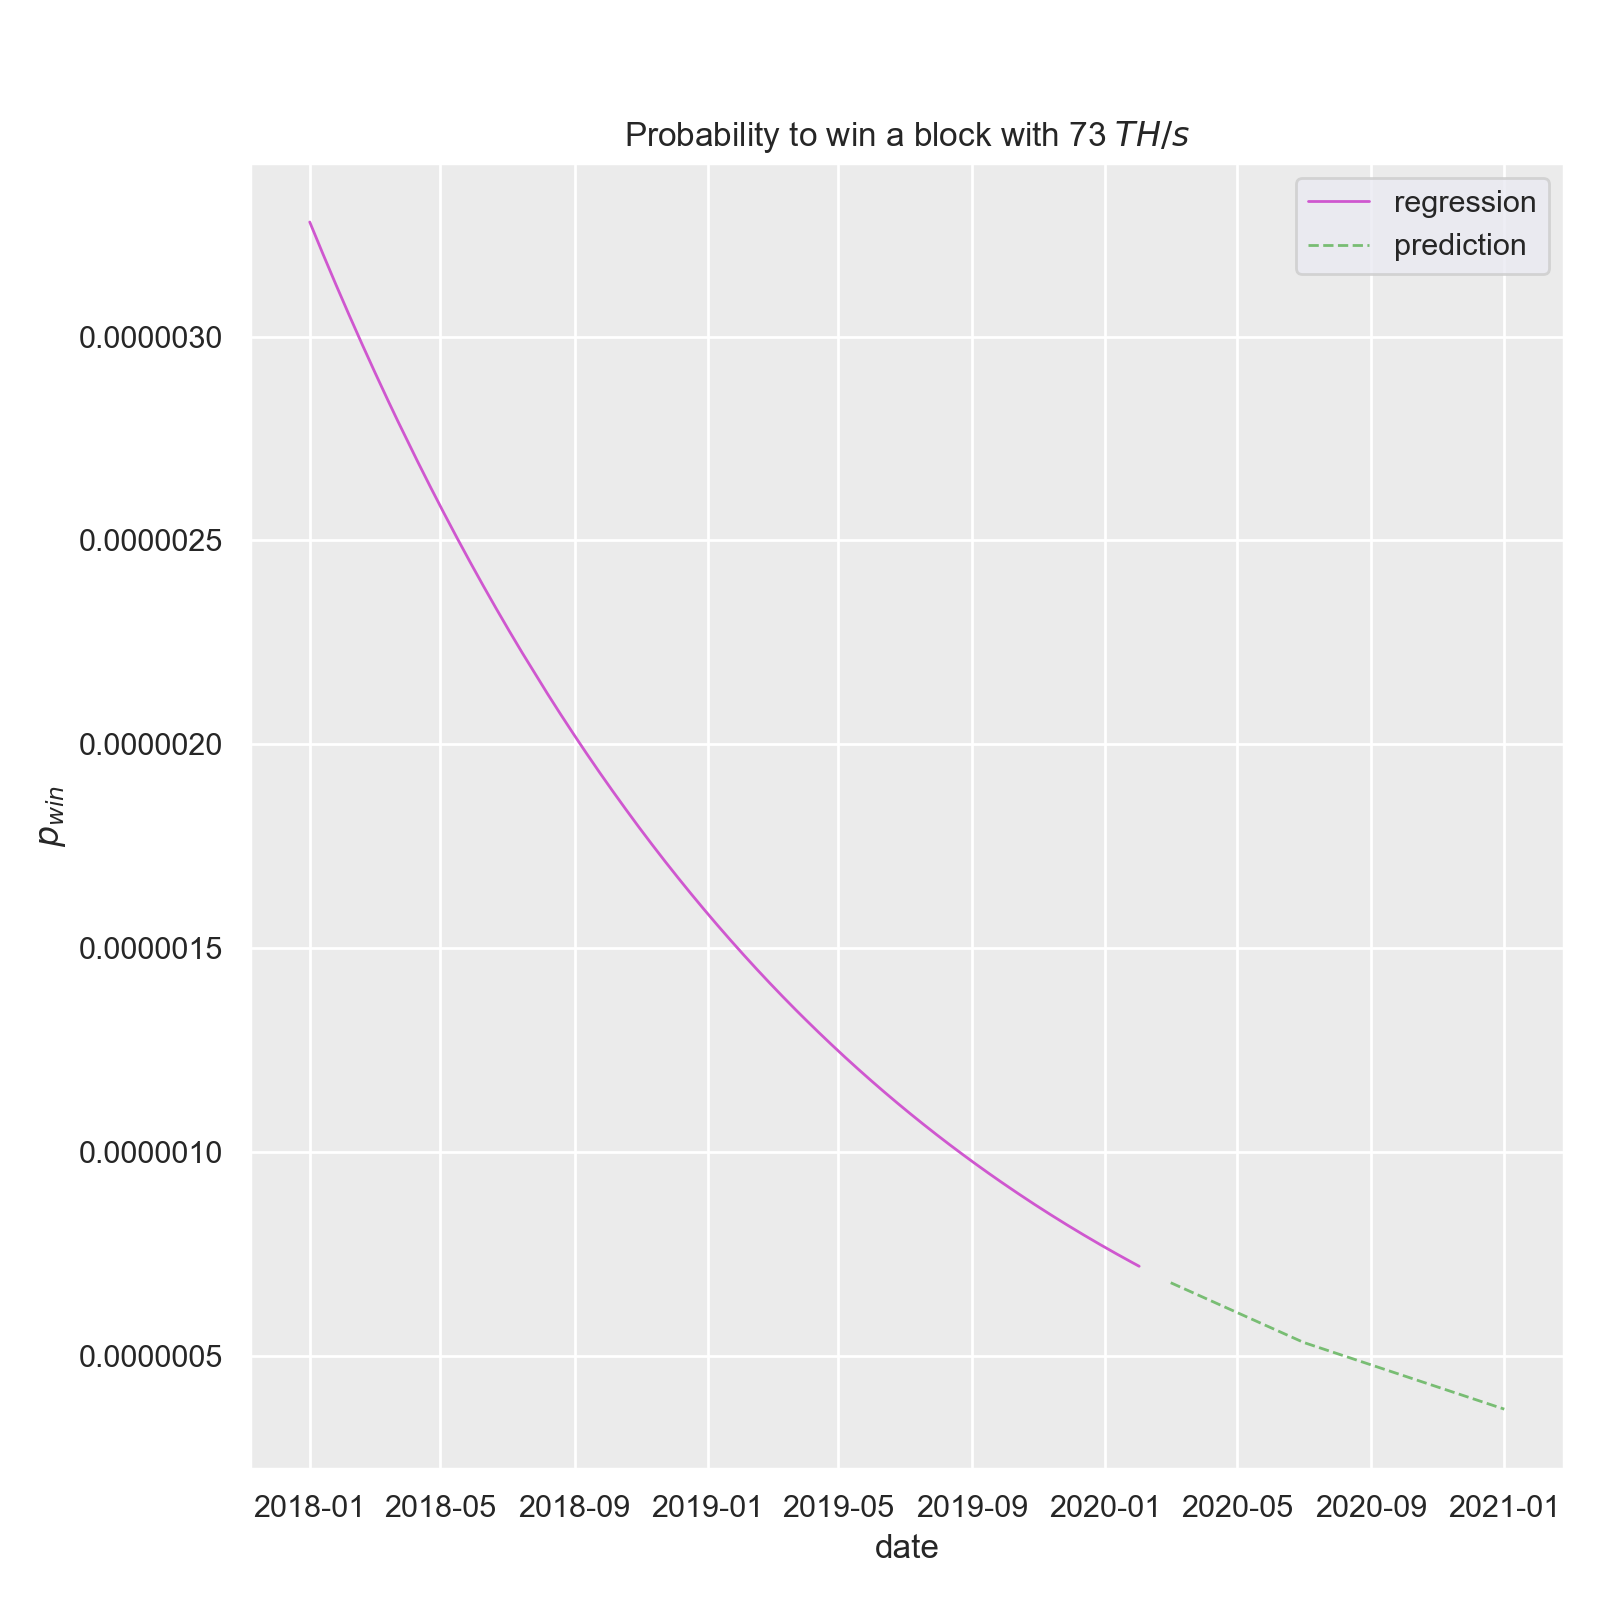

In [25]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top=.90)

ax2 = fig.add_subplot(111)
ax2.set_facecolor('#EBEBEB')
ax2.set_title('Probability to win a block with 73 $TH/s$')
ax2.set_ylabel('$p_{win}$')
ax2.set_xlabel('date')
ax2.plot(Ts, 73 * np.power(np.exp(reg.predict(X)), -1) , label='regression', c='#CF57CF', linewidth=1)
ax2.plot(PTs, 73 * np.power(np.exp(reg.predict(P)), -1) , label='prediction', c='#78BD73', linewidth=1, ls='--')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
m1 = reg.coef_[0]
q1 = reg.intercept_
print(m1, q1)

2.3081649361561667e-08 -18.04550761099243


In [17]:
import time;
ts = time.time()
print(int(ts))

1580890392


In [18]:
def tt(r):
    return 1580652314 + r*600

In [19]:
A = np.exp(q1)
def H(r):
    return A*np.exp(m1*tt(r))

In [20]:
class BTCExp:
    def __init__(self, TH, N, C, e, S, BTCUSD, m, q):
        self.TH = TH
        self.N = N
        self.P = N * TH / 73. * 2920 # watt
        self.BTCUSD = BTCUSD
        self.e = e
        self.S = S
        self.C = C
        self.c = self.C * TH / 73
        self.m = m
        self.q = q
    
    def computeExpectation(self, days):
        
        def tt(r):
            return 1580652314 + r*600
        
        A = math.exp(self.q)
        def H(r):
            return A*math.exp(self.m*tt(r))
        
        E = 0
        r = 0
        rt = days * 6 * 24
        while(r < rt):
            r += 1
            E += (self.N * self.TH) / (H(r) - (self.N * self.TH))
        
        self.r = r
        self.E = E
        self.results()
    
    def expectedBTC(self):
        return self.E * self.S
    
    def expectedValue(self):
        return self.expectedBTC() * self.BTCUSD
        
    def energy(self):
        return self.P / 1000. / 6. * self.r
    
    def totalCost(self):
        return self.energy() * self.e + self.c
    
    def results(self):
        print ('\n\n')
        print ('————————————————————————————————————————————————————————————')
        print ('Rounds           :', self.r, '(', self.r / 6 / 24, ') days')
        print ('————————————————————————————————————————————————————————————')
        print ('Device hash rate :', self.TH * self.N, 'TH/s' )
        print ('Expeted wins     :', self.E)
        print ('Subside  and fees:', self.S, 'BTC')
        
        print ('Expected BTCs    :', self.expectedBTC())
        print ('BTC/USD          :', self.BTCUSD, 'USD')
        print ('Expected Value   : %.5f %s' % (self.expectedValue(), 'USD'))
        print ('Energy consum.   :', self.energy(), 'kWh (28.95 W/TH/s)')
        print ('Energy price.    :', self.e, 'USD/kWh')
        print ('Energy cost      :', self.energy() * self.e, 'USD')
        print ('Device cost      :', self.c, 'USD')
        print ('                  ', '----------')
        print ('Total costs      :', self.totalCost())
        print ('Expected Profit  :', self.expectedValue() - self.totalCost())
        print ('         per kWh :', (self.expectedValue() - self.totalCost()) / self.energy() )
    

In [21]:
N = 1 # number of devices
h = 73*N # hash rate

In [24]:
m12 = BTCExp(h, N, 1000, 0.05, 12.5 + 0.05, 9450, m1, q1)
m12.computeExpectation(365)
m12.computeExpectation(365*2)




————————————————————————————————————————————————————————————
Rounds           : 52560 ( 365.0 ) days
————————————————————————————————————————————————————————————
Device hash rate : 73 TH/s
Expeted wins     : 0.02677296958438745
Subside  and fees: 12.55 BTC
Expected BTCs    : 0.3360007682840625
BTC/USD          : 9450 USD
Expected Value   : 3175.20726 USD
Energy consum.   : 25579.199999999997 kWh (28.95 W/TH/s)
Energy price.    : 0.05 USD/kWh
Energy cost      : 1278.96 USD
Device cost      : 1000.0 USD
                   ----------
Total costs      : 2278.96
Expected Profit  : 896.2472602843904
         per kWh : 0.03503812708311404



————————————————————————————————————————————————————————————
Rounds           : 105120 ( 730.0 ) days
————————————————————————————————————————————————————————————
Device hash rate : 73 TH/s
Expeted wins     : 0.03970218629545966
Subside  and fees: 12.55 BTC
Expected BTCs    : 0.4982624380080187
BTC/USD          : 9450 USD
Expected Value   : 4708.58004 

In [23]:
m6 = BTCExp(73, 1, 500, 0.05, (6.25 + .05), 9450, m1, q1)
m6.computeExpectation(365)
m6.computeExpectation(365*2)




————————————————————————————————————————————————————————————
Rounds           : 52560 ( 365.0 ) days
————————————————————————————————————————————————————————————
Device hash rate : 73 TH/s
Expeted wins     : 0.02677296958438745
Subside  and fees: 6.3 BTC
Expected BTCs    : 0.16866970838164091
BTC/USD          : 9450 USD
Expected Value   : 1593.92874 USD
Energy consum.   : 25579.199999999997 kWh (28.95 W/TH/s)
Energy price.    : 0.05 USD/kWh
Energy cost      : 1278.96 USD
Device cost      : 500.0 USD
                   ----------
Total costs      : 1778.96
Expected Profit  : -185.0312557934933
         per kWh : -0.007233660778816121



————————————————————————————————————————————————————————————
Rounds           : 105120 ( 730.0 ) days
————————————————————————————————————————————————————————————
Device hash rate : 73 TH/s
Expeted wins     : 0.03970218629545966
Subside  and fees: 6.3 BTC
Expected BTCs    : 0.2501237736613958
BTC/USD          : 9450 USD
Expected Value   : 2363.66966 U



$P(k) = e^{-\lambda}\dfrac{\lambda^{k}}{k!}$

$\lambda = \dfrac{h \cdot t}{2^{32}D}$

$P(k=1) = e^{-\lambda}\dfrac{\lambda^{1}}{1!} = e^{-\lambda}$

## Empirical estimates for the global hash rate

The global hash rate $H(t)$ cannot be measured directly (2)

$\widehat{H}_{i} = \dfrac{2^{32}}{600}D_{i+1}$

H * 600 = # hashes = (2^32 * D) = (2^32 * MAX_TARGET / CURRENT_TARGET)

CURRENT_TARGET viene da nBits
TARGET_MAX = 0x00000000FFFF0000000000000000000000000000000000000000000000000000

Happy!!! Capito !!!

In [30]:
Hh = math.pow(2, 32)/600*15466098935554.65
Hh/1e18

110.71064854151273

In [54]:
def lam(h, t, D):
    return (h*t)/(math.pow(2, 32)*D)

def P(lam):
    return 1 - math.exp(-lam)

def days(n):
    return n * 24 * 60 * 60

In [52]:
lam(77*1e12, 600, 15466098935554.65)

6.955067196731994e-07

In [55]:
P(lam(1*1e9, days(1), 1690906)) # h = 1GH/s, D = 1690906, t = 1 day

0.011826428068078876

In [57]:
P(lam(73*1e12, days(1), 15466098935554.65)) # h = 73GH/s, D = 15466098935554.65, t = 1 day

9.494570843848749e-05

In [60]:
P(lam(73*1e12, 600, 15466098935554.65)) # h = 73GH/s, D = 15466098935554.65, t = 1 round

6.593762831297312e-07

In [59]:
P(lam(73*1e12, days(365), 15466098935554.65)) # h = 73GH/s, D = 15466098935554.65, t = 1 year

0.034063158971002094

In [62]:
77*1e12/(110*1e18)

7e-07

In [63]:
77*1e12/(math.pow(2, 32)/600*15466098935554.65) # lambda

6.955067196731994e-07

In [72]:
 math.log(1533267872647776902154320487930659211795065581998445848740226310)/math.log(2)

209.89807974585946

In [14]:
D = 15466098935554.65
p = 1. / (np.power(2, 32)*D)
E = 1 / p
v = (1 - p) / (np.power(p, 2))

In [22]:

'{0:.2e} {1: .2e}  {1: .2e} {2: .2e}'.format(D, p, E, v)

'1.55e+13  1.51e-23   1.51e-23  6.64e+22'